## Overview
The algorithms in MUQ leverage models that are defined through the `ModPiece` and `WorkGraph` classes.   This example demonstrates how to implement a model with gradient and Hessian information as a child of the `ModPiece` class.  A finite element implementation of the groundwater flow equation is employed with adjoint techniques for computing gradients and Hessian actions.

One dimensional steady state groundwater flow in a confined aquifer can be modeled using the following PDE
$$
\begin{aligned}
-\frac{\partial}{\partial x}\left[ k(x) \frac{\partial h}{\partial x}\right] &= f(x)\\
h(0) &= 0\\
\left. \frac{\partial h}{\partial x}\right|_{x=1} &= 0,
\end{aligned}
$$
where $h(x)$ is the pressure (more generally the hydraulic head), $k(x)$ is a spatially distribution parameter called the hydraulic conductivity, and $f(x)$ is a source term.  For simplicity, we assume $x\in\Omega$, where $\Omega=[0,1]$.    While we will interpret this PDE through the lens of groundwater flow, the same equation arises in many disciplines, including heat conduction and electrostatics.  

<img src="DarcyFlow.png" style="float:right"></img>

Given a particular conductivity field $k(x)$, the PDE above can be used to compute the pressure $h(x)$.   We will leverage this relationship to construct a `ModPiece` that takes a vector defining $k(x)$ as input and returns a vector defining $h(x)$.    

At the end of this example, the finite element flow equation model is combined with a simple Gaussian density to imitate a Bayesian likelihood function.  The Hessian of this likelihood function is studied by computing the Hessian's spectrum using MUQ's stochastic eigenvalue solver.


## Finite Element Formulation
Here we derive the finite element discretization as well as the adjoint equations for gradient and hessian operations.   *This section focuses exclusively on the details of the finite element discretization.  Nothing MUQ-specific is discussed until the `Implementation` section below.*  Readers familiar with finite element methods can skip ahead to that section with the knowledge that linear basis functions are used for representing $h(x)$, piecewise constant basis functions are used for $K(x)$, and all integrals are computed analytically.

#### Forward Model Discretization
To discretize the flow model PDE with a finite element method, we first need to consider the PDE in weak form.   Let $\mathcal{H}$ denote a Hilbert space of functions on $\Omega$ that satisfy the Dirichlet boundary condition $h(0)=0$.   For any function $p\in\mathcal{H}$, we have from the PDE that
$$
\int_\Omega p(x) \left[\frac{\partial}{\partial x}\left[ k(x) \frac{\partial h}{\partial x}\right] + f(x) \right] dx = 0
$$
Using integration by parts and applying the boundary conditions, we obtain the weak form of the flow equation, which is given by
$$
\int_\Omega k \frac{\partial p}{\partial x} \frac{\partial h}{\partial x} dx - \int_\Omega f p dx= 0.
$$
Our goal is to find the function $h$ such that this expression is satisfied for all functions $p$.  For this to be computationally feasible, we first need to represent the functions $h(x)$ and $p(x)$ through a finite number of basis functions.  Using a standard Galerkin discretization, we represent both $h$ and $p$ with the set of basis functiosn $\phi^1_i(x)$:
$$
\begin{aligned}
h(x) & = \sum_{i=1}^{N+1} h_i \phi^1_i(x)\\
p(x) & = \sum_{i=1}^{N+1} p_i \phi^1_i(x),
\end{aligned}
$$
where $h_i,p_i\in \mathbb{R}$ are weights on the basis function $\phi^1_i(x)$.  Here, we consider linear basis functions (also known as "hat" functions) given by 
$$
\phi^1_i(x) = \left\{ \begin{array}{ll} \frac{x-x_{i-1}}{x_i-x_{i-1}} & x\in[x_{i-1},x_i]\\ \frac{x_{i+1}-x}{x_{i+1}-x_i} & x\in(x_i,x_{i+1}] \\ 0 & \text{otherwise} \end{array} \right.,
$$
where $[x_0,x_1,\ldots,x_{N+1}]$ is an increasing sequence of node locations splitting the domain $\Omega$ into $N$ cells.  We will further assume uniform node spacing is constant so that $x_{i+1}-x_i = \delta x$ for all $i$.

A similar approach is used to discretize the conductivity $k(x)$ and source term $f(x)$.  In particular, we let 
$$
\begin{aligned}
k(x) &= \sum_{i=1}^N k_i \phi^0_i(x)\\
f(x) &= \sum_{i=1}^N f_i \phi^0_i(x),
\end{aligned}
$$
but consider piecewise constant basis functions 
$$
\phi^0_i(x) = \left\{\begin{array}{ll} 1 & x\in[x_{i},x_{i+1})\\ 0 & \text{otherwise} \end{array}\right.
$$
so that $k(x)$ and $f(x)$ are piecewise constant.  With these discretizations in hand, the weak form becomes
$$
\begin{aligned}
\int_\Omega k \frac{\partial p}{\partial x} \frac{\partial h}{\partial x} dx - \int_\Omega f p dx & = \int_\Omega \left(\sum_{n=1}^N k_n \phi_n^0(x) \right) \left(\sum_{i=1}^{N+1}p_i \frac{\partial \phi^1_i}{\partial x}\right) \left(\sum_{j=1}^{N+1}h_j \frac{\partial \phi^1_j}{\partial x}\right) dx - \int_\Omega \left(\sum_{n=1}^N f_n \phi_n^0(x) \right) \left(\sum_{i=1}^{N+1}p_i \phi^1_i \right) dx.
\end{aligned}
$$
For this quantity to be zero for all functions $p\in\text{span}(\{\phi_1^1,\ldots,\phi_{N+1}^1\})$, we require that 
$$
\begin{aligned}
& \int_\Omega \frac{\partial \phi^1_i}{\partial x} \left(\sum_{n=1}^N k_n \phi_n^0(x) \right)  \left(\sum_{j=1}^{N+1}h_j \frac{\partial \phi^1_j}{\partial x}\right) dx  - \int_\Omega \phi_i^1 \left(\sum_{k=1}^N f_k \phi_k^0(x) \right) dx &= 0\\
\Rightarrow & \sum_{j=1}^{N+1}\sum_{n=1}^N \left[ h_j k_n \int_\Omega \phi_n^0(x) \frac{\partial \phi^1_i}{\partial x} \frac{\partial \phi^1_j}{\partial x} dx - f_n \int_\Omega \phi_i^1(x)\phi_n^0(x) dx \right] & = 0
\end{aligned}
$$
for all $i$.  Notice that this defines a linear system of equations $\mathbf{A} \mathbf{h} = \mathbf{f}$, where $\mathbf{h}=[h_1,\ldots,h_{N+1}]$ is a vector of coefficients, $\mathbf{A}$ is a matrix with components given by 
$$
\mathbf{A}_{ij} = \sum_{n=1}^N k_n \int_{x_n}^{x_{n+1}} \frac{\partial \phi^1_i}{\partial x} \frac{\partial \phi^1_j}{\partial x} dx,
$$
and 
$$
\mathbf{f}_i = \sum_{n=1}^N f_n \int_{x_n}^{x_{n+1}} \phi_i^1(x) dx.
$$

Notice that the matrix $\mathbf{A}$ is symmetric.   This has important consequences for the adjoint and incremental adjoint problems described below.

To approximately solve the flow equation, we need to construct the stiffness matrix $\mathbf{A}$ and the right hand side vector $\mathbf{f}$ before solving $\mathbf{h} = \mathbf{A}^{-1}\mathbf{f}$ to obtain the coefficients $h_i$.



#### Adjoint-based Gradient Computation
Many sampling, optimization, and dimension reduction algorithms require derivative information.   Here we consider adjoint strategies for efficient computing gradients of functionals $J(h)$ with respect to the conductivity field $k(x)$.  A natural way to do this is to consider the following constrained optimization problem
$$
\begin{aligned}
\min_{h,k}\quad & J(h)\\
\text{s.t.}\quad & \frac{\partial}{\partial x}\left[ k(x) \frac{\partial h}{\partial x}\right] + f(x) = 0.
\end{aligned}
$$ 
Using a Lagrange multiplier $p(x)$, we can form the Lagrangian $\mathcal{L}(h,k,p)$ associated with this optimization problem and solve for optimality conditions. The Lagrangian is given by
$$
\mathcal{L}(h,k,p) = J(h) - \int_\Omega p \frac{\partial}{\partial x}\left[ k \frac{\partial h}{\partial x}\right] dx - \int_\Omega p f dx.
$$ 
Note that the explicit dependence of $h$, $k$, and $p$ on $x$ has been dropped for clarity.    Using integration by parts, we can "move" the derivative on $k \frac{\partial h}{\partial x}$ to a derivative on $p$, resulting in 
$$
\mathcal{L}(h,k,p) = J(h) - \left.\left(p k \frac{\partial h}{\partial x}\right)\right|_{0}^{1} + \int_\Omega k \frac{\partial p}{\partial x} \frac{\partial h}{\partial x} dx - \int_\Omega p f dx.
$$
Recall that $p(0)=0$ because of the Dirichlet condition at $x=0$.  Combined with the boundary condition $\partial h / \partial dx = 0$ at $x=1$, the Lagrangian can be simplified to 
$$
\mathcal{L}(h,k,p) = J(h) + \int_\Omega k \frac{\partial p}{\partial x} \frac{\partial h}{\partial x} dx - \int_\Omega p f dx.
$$

We now consider the first variations of the Lagrangian with respect to each input.   Recall that the first variation of a functional $G(m)$ is a function $G_m(m)(\tilde{m})$ representing the directional derivative of the functional $G$ in the direction $\tilde{m}$ and is defined as 
$$
G_m(m)(\tilde{m}) = \left. \frac{\partial}{\partial \epsilon} G(m+\epsilon\tilde{m}) \right|_{\epsilon=0},
$$
where $\epsilon\in\mathbb{R}$ is a scalar step size.

Using this definition, the first variation of $\mathcal{L}$ with respect to $h$ is given by
$$
\begin{aligned}
\mathcal{L}_h(h,k,p)(\tilde{h}) &= \left. \frac{\partial}{\partial \epsilon} \mathcal{L}(h+\epsilon \tilde{h},k,p) \right|_{\epsilon=0}\\
&= \left. \frac{\partial}{\partial \epsilon}\left[J(h+\epsilon \tilde{h}) +\int_\Omega k \frac{\partial p}{\partial x} \frac{\partial (h+\epsilon\tilde{h})}{\partial x} dx - \int_\Omega p f dx\right] \right|_{\epsilon=0}\\
&= J_h(h)(\tilde{h}) + \int_\Omega k \frac{\partial p}{\partial x}\frac{\partial \tilde{h}}{\partial x} dx.
\end{aligned}
$$

Similarly, the first variation with respect $p$ is 
$$
\begin{aligned}
\mathcal{L}_p(h,k,p)(\tilde{p}) &= \left. \frac{\partial}{\partial \epsilon} \mathcal{L}(h,k,p+\epsilon \tilde{p}) \right|_{\epsilon=0}\\
&= \left. \frac{\partial}{\partial \epsilon}\left[J(h) + \int_\Omega k \frac{\partial (p+\epsilon \tilde{p})}{\partial x} \frac{\partial h}{\partial x} dx - \int_\Omega (p+\epsilon \tilde{p}) f dx\right] \right|_{\epsilon=0}\\
&= \int_\Omega k \frac{\partial \tilde{p}}{\partial x}\frac{\partial h}{\partial x} dx - \int_\Omega \tilde{p} f dx.
\end{aligned}
$$

And finally, the first variation with respect to $k$ is given by
$$
\begin{aligned}
\mathcal{L}_k(h,k,p)(\tilde{k}) &= \left. \frac{\partial}{\partial \epsilon} \mathcal{L}(h,k+\epsilon \tilde{k},p) \right|_{\epsilon=0}\\
&= \left. \frac{\partial}{\partial \epsilon} \left[ J(h) + \int_\Omega (k+\epsilon\tilde{k}) \frac{\partial p}{\partial x} \frac{\partial h}{\partial x} dx - \int_\Omega p f dx\right] \right|_{\epsilon=0}\\
&=\int_\Omega \tilde{k}\frac{\partial h}{\partial x} \frac{\partial p}{\partial x} dx
\end{aligned}
$$

The solution of the optimization problem is given by the functions $(h,k,p)$ that cause all of these first variations to be zero for all admissable directions $\tilde{h}$, $\tilde{p}$, and $\tilde{k}$.  Solving  $\mathcal{L}_p(h,k,p)(\tilde{p})=0$ for all $\tilde{p}$ yields the weak form of the original elliptic PDE -- the "forward problem."  Solving $\mathcal{L}_h(h,k,p)(\tilde{h})$ for all $\tilde{h}$ results in the weak form of the adjoint equation.   Finally, the constraint $\mathcal{L}_k(h,k,p)(\tilde{k})=0$ provides a definition of the gradient using the solutions of the forward and adjoint equations.  The gradient is given by $\nabla_k J = \frac{\partial h}{\partial x} \frac{\partial p}{\partial x}$.

To intuitively interpret $\nabla_k J$ as the gradient, it helps to compare the inner product of $\tilde{k}$ and $\nabla_k J$ in the definition of $\mathcal{L}_k(h,k,p)(\tilde{k})$ with the definition of a directional derivative in a finite dimensional space.   Consider the relationship between the gradient and directional derivative of a function $g(y)$ mapping $\mathbb{R}^N\rightarrow\mathbb{R}$.   The derivative of $g$ in a unit direction $\tilde{y}$ is given by the inner product of the gradient and the direction: $\tilde{y}\cdot \nabla_y g$.  Comparing this to the first variation $\mathcal{L}_k(h,k,p)(\tilde{k})$, we see that the integral $\int_\Omega \tilde{k}\frac{\partial h}{\partial x} \frac{\partial p}{\partial x} dx$ is just an inner product of the direction $\tilde{k}$ with $\nabla_kJ$.  $\nabla_kJ$ is therefore the functional gradient of $J$ with respect to the conductivity $k$.

Notice that the adjoint equation has the same form as the forward model but with a different right hand side.  This is because the flow equation is self-adjoint.   Self-adjoint operators are numerically convenient because we can reuse the same finite element discretization of the forward problem to also solve the adjoint equation.  In particular, we can solve the linear system $\mathbf{A} \mathcal{p} = \nabla_h J$, where $\mathbf{A}$ is the same matrix as before, and $\nabla_h J$ is a vector containing the gradient of $J$ with respect to the coefficients $\mathbf{h}_i$.  The solution of this linear system can then be used to obtain the derivative of $J$ with respect to each coefficient $k_i$ defining the conductivity field: 
$$
\frac{\partial J}{\partial K_i} = \frac{ \mathbf{h}_{i+1}-\mathbf{h}_{i}}{x_{i+1}-x_i} \frac{\mathbf{p}_{i+1} - \mathbf{p}_i}{x_{i+1} - x_i}.
$$

Note that obtaining the gradient with this approach only requires one extra linear solve to obtain the adjoint variable $\mathbf{p}$ and that a factorization of the stiffness matrix $\mathbf{A}$ can be resued.  This is in stark contrast to a finite difference approximation that would require $N$ additional solves -- one for each derivative $\frac{\partial J}{\partial k_i}$.  


#### Jacobian Actions

The gradient computation above performs one step of the chain rule, which is equivalent to applying the transpose of the model Jacobian (i.e., linearized $k\rightarrow h$ mapping) to the sensitivity vector $\nabla_h J$.   It is also possible to efficiently apply the Jacobian itself to a vector $v$ using what is often called the tangent linear model.   To see this, consider a small perturbation $\tilde{k}(x)$ of the conductivity field $k(x)$.  This perturbation will then cause a perturbation $\tilde{h}$ of the original solution $h$.   The tangent linear model relates $\tilde{k}$ and $\tilde{h}$ by ignoring higher order terms like $\tilde{k}^2$ or $\tilde{k}\tilde{h}$.   

To derive the tangent linear model for this problem, consider what happens when we substitute the perturbed fields $k+\tilde{k}$ and $h+\tilde{h}$ into the flow equation.   The result is
$$
\begin{aligned}
-\frac{\partial}{\partial x}\left[ (k+\tilde{k}) \frac{\partial (h+\tilde{h})}{\partial x}\right] &= f(x)\\
\tilde{h}(0) &= 0\\
\left. \frac{\partial \tilde{h}}{\partial x}\right|_{x=1} &= 0,
\end{aligned}
$$

Expanding terms, removing higher order terms, and simplifying then gives 

$$
\begin{aligned}
-\frac{\partial}{\partial x}\left[ k \frac{\partial h}{\partial x}\right] -\frac{\partial}{\partial x}\left[ \tilde{k} \frac{\partial h}{\partial x}\right] -\frac{\partial}{\partial x}\left[ k \frac{\partial \tilde{h}}{\partial x}\right] -\frac{\partial}{\partial x}\left[ \tilde{k} \frac{\partial \tilde{h}}{\partial x}\right] &= f(x)\\
\Rightarrow -\frac{\partial}{\partial x}\left[ k \frac{\partial \tilde{h}}{\partial x}\right]  &= \frac{\partial}{\partial x}\left[ \tilde{k} \frac{\partial h}{\partial x}\right].
\end{aligned}
$$
The weak form of this linear tangent model is given by
$$
\begin{aligned}
\Rightarrow \int_\Omega k \frac{\partial p}{\partial x} \frac{\partial \tilde{h}}{\partial x} dx & = -\int_\Omega \tilde{k} \frac{\partial p}{\partial x} \frac{\partial h}{\partial x} dx \quad \forall p\in H^1
\end{aligned}
$$

Yet again, this equation has the same form as the forward and adjoint equations!   The only difference is the right hand side.   This shared form is not the case for most operators, but makes the implementation of this model quite easy because we only need one function to construct the stiffness matrix.

Using the vector $\mathbf{h}$ of nodal values, the weak form of the tangent linear model results in a linear system of the form 
$$
\mathbf{A} \mathbf{\tilde{h}} = \mathbf{t},
$$
where entry $i$ of the right hand side is given by
$$
\begin{aligned}
\mathbf{t}_i & = \int_{x_{i-1}}^{x_i} \tilde{k} \frac{\partial \phi_i^1}{\partial x} \frac{\partial h}{\partial x} dx + \int_{x_{i}}^{x_{i+1}} \tilde{k} \frac{\partial \phi_i^1}{\partial x} \frac{\partial h}{\partial x} dx\\
&= \left[ \tilde{k}_{i-1} \frac{\mathbf{h}_i - \mathbf{h}_{i-1}}{x_i - x_{i-1}} \right] (x_i - x_{i-1}) + \left[ \tilde{k}_{i} \frac{\mathbf{h}_{i+1} - \mathbf{h}_{i}}{x_{i+1} - x_{i}} \right] (x_{i+1} - x_{i}) \\
&= \tilde{k}_{i-1} (\mathbf{h}_i - \mathbf{h}_{i-1}) + \tilde{k}_{i} (\mathbf{h}_{i+1} - \mathbf{h}_{i}).
\end{aligned}
$$

To apply the Jacobian to $\tilde{k}$, we need to solve the forward problem to get $h$, then construct the right hand side vector $\mathbf{t}$ from the direction $\tilde{k}$, and finally solve $\mathbf{\tilde{h}} = \mathbf{A}^{-1}\mathbf{t}$ to get $\tilde{h}$. 


#### Adjoint-based Hessian actions
Second derivative information can also be exploited by many different UQ, optimization, and dimension reduction algorithms.  Newton methods in optimization are a classic example of this.  Here we extend the adjoint gradient from above to efficiently evaluate the action of the Hessian operator $\nabla_{kk} J$ on a function $\hat{k}$.   After discretizing, this is equivalent to multiplying the Hessian matrix times a vector.

Recall from the adjoint gradient discussion above that $\mathcal{L}_k(h,k,p)(\tilde{k})$ is a scalar quantity that represents the directional derivative of the Lagrangian in direction $\tilde{k}$ when $\mathcal{L}_p(h,k,p)(\tilde{p})=0$ for all $\tilde{p}$ and $\mathcal{L}_h(h,k,p)(\tilde{h})=0$ for all $\tilde{h}$.   To characterize the Hessian, we now want to consider the change in this scalar quantity when $k$ is perturbed in another direction.  In an abstract sense, this is identical to our adjoint approach for the gradient, however, instead of considering the scalar functional $J(h)$ to construct a Lagrangian, we will the scalar functional $\mathcal{L}_k(h,k,p)(\tilde{k})$.

To characterize a second directional derivative, we can form another (meta-)Lagrangian using $\mathcal{L}_k(h,k,p)(\tilde{k})$ and the constraints $\mathcal{L}_p(h,k,p)(\tilde{p})=0$ and $\mathcal{L}_h(h,k,p)(\tilde{h})=0$.  The strong form of these constraints is given by
$$
\begin{aligned}
-\frac{\partial}{\partial x}\left[ k(x) \frac{\partial h}{\partial x}\right] &= f(x)\\
h(0) &= 0\\
\left. \frac{\partial h}{\partial x}\right|_{x=1} &= 0,
\end{aligned}
$$
and 
$$
\begin{aligned}
-\frac{\partial}{\partial x}\left[ k(x) \frac{\partial p}{\partial x}\right] &= D_hJ(x)\\
p(0) &= 0\\
\left. \frac{\partial p}{\partial x} \right|_{x=1} &= 0.
\end{aligned}
$$

In addition to introducing two additional Lagrange multipliers $\hat{p}$ and $\hat{h}$, we will also introduce a new function $s=\nabla_hJ(h)$ to represent the sensitivity of the objective functional $J(h)$ with respect to $h$.  Notice that we will not directly consider second variations of $J$.  Instead, we independently consider the action of Hessian on functions $\bar{k}$ and $\bar{s}$, which is what MUQ will need to propagate second derivative information through a composition of model components.

Using $\hat{p}$, $\hat{h}$, and $s$, the meta-Lagrangian $\mathcal{L}^H$ takes the form
$$
\begin{aligned}
\mathcal{L}^H(h,k,p,\hat{h},\hat{p}, s; \tilde{k}) &= \int_\Omega \tilde{k}\frac{\partial h}{\partial x} \frac{\partial p}{\partial x} dx - \int_\Omega \hat{p} \left( \frac{\partial}{\partial x}\left[ k \frac{\partial h}{\partial x}\right] + f\right) dx - \int_\Omega \hat{h}\left(\frac{\partial}{\partial x}\left[ k \frac{\partial p}{\partial x}\right] + s \right) dx \\
&=  \int_\Omega \tilde{k}\frac{\partial h}{\partial x} \frac{\partial p}{\partial x} dx + \int_\Omega k \frac{\partial \hat{p}}{\partial x}\frac{\partial h}{\partial x} dx - \int_\Omega \hat{p} f dx + \int_\Omega k \frac{\partial \hat{h}}{\partial x}\frac{\partial p}{\partial x} dx - \int_\Omega \hat{h} s dx
\end{aligned}
$$
Placing the $\tilde{k}$ after the semicolon in the arguments to  $\mathcal{L}^H$ is meant to indicate that the direction $\tilde{k}$ is a parameter defining the first directional derivative and is not an argument that needs to be considered when taking first variations.


The first variation with respect to $p$ is given by
$$
\begin{aligned}
\mathcal{L}_{p}^H(h,k,p,\hat{h},\hat{p}, s; \tilde{k})(\bar{p}) & = \left. \frac{\partial}{\partial \epsilon} \mathcal{L}^H(h,k,p+\epsilon\bar{p},\hat{h},\hat{p}, s; \tilde{k}) \right|_{\epsilon=0}\\
& =  \left. \frac{\partial}{\partial \epsilon} \left( \int_\Omega \tilde{k}\frac{\partial h}{\partial x} \frac{\partial (p+\epsilon\bar{p})}{\partial x} dx + \int_\Omega k \frac{\partial \hat{p}}{\partial x}\frac{\partial h}{\partial x} dx - \int_\Omega \hat{p} f dx + \int_\Omega k \frac{\partial \hat{h}}{\partial x}\frac{\partial (p+\epsilon\bar{p})}{\partial x} dx \right)\right|_{\epsilon=0}\\
& = \int_\Omega \tilde{k}\frac{\partial h}{\partial x} \frac{\partial \bar{p}}{\partial x} dx + \int_\Omega k \frac{\partial \hat{h}}{\partial x}\frac{\partial \bar{p}}{\partial x} dx 
\end{aligned}
$$
This expression defines what is commonly called the *incremental forward problem.*

The first variation of this meta-Lagrangian with respect to $h$ is given by.
$$
\begin{aligned}
\mathcal{L}_{h}^H(h,k,p,\hat{h},\hat{p}, s; \tilde{k})(\bar{h}) & = \left. \frac{\partial}{\partial \epsilon} \mathcal{L}^H(h+\epsilon\bar{h},k,p,\hat{h},\hat{p}, s; \tilde{k}) \right|_{\epsilon=0}\\
&= \left. \frac{\partial}{\partial \epsilon} \left( \int_\Omega \tilde{k}\frac{\partial (h+\epsilon\bar{h})}{\partial x} \frac{\partial p}{\partial x} dx + \int_\Omega k \frac{\partial \hat{p}}{\partial x}\frac{\partial (h+\epsilon\bar{h})}{\partial x} dx - \int_\Omega \hat{p} f dx + \int_\Omega k \frac{\partial \hat{h}}{\partial x}\frac{\partial p}{\partial x} dx - \int_\Omega \hat{h}\, s dx \right)\right|_{\epsilon=0} \\
&= \int_\Omega \tilde{k}\frac{\partial \bar{h}}{\partial x} \frac{\partial p}{\partial x} dx + \int_\Omega k \frac{\partial \hat{p}}{\partial x}\frac{\partial \bar{h}}{\partial x} dx.
\end{aligned}
$$
This expression defines the *incremental adjoint problem.*  Notice that both incremental problems have the same bilinear form $\int_\Omega k \frac{\partial \hat{h}}{\partial x}\frac{\partial \bar{p}}{\partial x} dx$ that is present in the forward and adjoint problems.  Just like we were able to reuse the matrix $\mathbf{A}$ from the forward problem in the adjoint problem, we can also use $\mathbf{A}$ to solve both incremental problems.

Finally, the first variation with respect to $k$ is
$$
\begin{aligned}
\mathcal{L}_{k}^H(h,k,p,\hat{h}, \hat{p}, s; \tilde{k})(\bar{k}) &= \left. \frac{\partial}{\partial \epsilon} \mathcal{L}^H(h,k+\epsilon \bar{k},p,\hat{h},\hat{p},s; \tilde{k}) \right|_{\epsilon=0}\\
&= \left. \frac{\partial}{\partial \epsilon}\left( \int_\Omega \tilde{k}\frac{\partial h}{\partial x} \frac{\partial p}{\partial x} dx + \int_\Omega (k+\epsilon \bar{k}) \frac{\partial \hat{p}}{\partial x}\frac{\partial h}{\partial x} dx - \int_\Omega \hat{p} f dx + \int_\Omega (k+\epsilon\bar{k}) \frac{\partial \hat{h}}{\partial x}\frac{\partial p}{\partial x} dx - \int_\Omega \hat{h} D_hJ dx \right) \right|_{\epsilon=0} \\
&= \int_\Omega \bar{k} \frac{\partial \hat{p}}{\partial x}\frac{\partial h}{\partial x} dx +\int_\Omega\bar{k} \frac{\partial \hat{h}}{\partial x} \frac{\partial p}{\partial x} dx.
\end{aligned}
$$
Combined with the incremental solution fields $\hat{h}$ and $\hat{p}$, this expression allows us to apply the Hessian to an input $\tilde{k}$.   The action of the Hessian, denoted here by $\nabla_{kk}J$, on the function $\tilde{k}$ is given by 
$$
(\nabla_{kk}J ) \tilde{k} = \frac{\partial \hat{p}}{\partial x}\frac{\partial h}{\partial x} + \frac{\partial \hat{h}}{\partial x} \frac{\partial p}{\partial x}.
$$
Note that $\tilde{k}$ is implicitly contained in the right hand side of this expression through $\hat{p}$ and $\hat{h}$.


## Implementation
MUQ implements components of models through the `ModPiece`.  Readers that are not familiar with the `ModPiece` class should consult the [model compoents tutorial](https://mituq.bitbucket.io/source/_site/latest/group__modpieces.html) before proceeding. 

To define the adjoint-enabled flow equation solver derived above, we need to override 3 methods in the `ModPiece` base class: the `EvaluateImpl` function, which will solve $\mathbf{A}\mathbf{h}=\mathbf{f}$, the `GradientImpl` function, which will solve $\mathbf{A}p=\mathbf{s}$ and compute the gradient, and finally, the `ApplyHessianImpl` function, which will solve the incremtnal forward and adjoint problems for $\hat{\mathbf{p}}$ and $\hat{\mathbf{h}}$ before returning the Hessian action.  These functions are all contained in the `FlowEquation` class below.

Notice that all of these function require constructing the stiffness matrix $\mathbf{K}$.   To avoid duplicitous code, the `FlowEquation` class therefore contains a `BuildStiffness` function that accepts a numpy vector of hydraulic conductivities and returns a scipy sparse matrix containing $\mathbf{K}$.

To implement the boundary Dirichlet boundary condition $h(x=0)=0$, we ensure that $\mathbf{f}_0 = 0$ and that $\mathbf{A}_{0,0}=c$ for some large value $c$ (e.g., $10^{10}$).   This is a common "trick" for enforcing Dirichlet boundary conditions while ensuring the stiffness matrix $\mathbf{A}$ remains symmetric. 

### Imports
In addition to the MUQ modeling module, we'll need numpy and scipy for sparse linear algebra.  Matplotlib will also be used for plotting.

In [1]:
import muq.Modeling as mm

import numpy as np

import scipy.sparse as sp
import scipy.sparse.linalg as spla

import matplotlib.pyplot as plt


### Class Definition

In [2]:
class FlowEquation(mm.PyModPiece):
    """
    This class solves the 1D elliptic PDE of the form
    $$
    -\frac{\partial}{\partial x}\cdot(k(x) \frac{\partial h}{\partial x}) = f(x).
    $$
    over $x\in[0,1]$ with boundary conditions $h(0)=0$ and
    $\partial h/\partial x =0$ at $x=1$.  This equation is a basic model of steady
    state fluid flow in a porous media, where $h(x)$ is the hydraulic head, $K(x)$
    is the hydraulic conductivity, and $f(x)$ is the recharge.

    This ModPiece uses linear finite elements on a uniform grid. There is a single input,
    the conductivity $K(x)$, which is represented as piecewise constant within each
    of the $N$ cells.   There is a single output of this ModPiece: the head $h(x)$ at the
    $N+1$ nodes in the discretization.
    
    INPUTS:
        sourceTerm (np.array) : A numpy array containing the value of the source term $f(x)$ in each grid cell.

    """

    def __init__(self, sourceTerm):
        super(FlowEquation,self).__init__([sourceTerm.shape[0]],   # inputSizes  (one for each cell)
                                          [sourceTerm.shape[0]+1]) # outputSizes (one for each node)
        
        self.numCells = sourceTerm.shape[0]
        self.numNodes = self.numCells+1
        
        self.xs = np.linspace(0,1,self.numNodes) # Assumes domain is [0,1]
        self.dx = self.xs[1]-self.xs[0] 
        
        self.rhs = self.BuildRhs(sourceTerm)
        
        
    def EvaluateImpl(self, inputs):
        """ Constructs the stiffness matrix and solves the resulting linear system.

            INPUTS:
                inputs: A list of vector-valued inputs.  Our model only has a single input,
                        so this list will also have one entry containing a vector of
                        conductivity values for each cell.

            RETURNS:
                This function returns nothing.  It stores the result in the private
                ModPiece::outputs list that is then returned by the `Evaluate` function.
        """

        condVals = inputs[0]

        # Build the stiffness matrix and right hand side
        A = self.BuildStiffness(condVals)

        # Solve the sparse linear system
        sol = spla.spsolve(A,self.rhs)

        # Set the output list using the solution
        self.outputs = [sol]

        
    def GradientImpl(self, outWrt, inWrt, inputs, sensitivity):
        """ This function computes one step of the chain rule to compute the gradient 
            $\nabla_k J$ of $J$ with respect to the input parameters.  In addition 
            to the model parameter $k$, this function also requires the sensitivity of 
            $J$ with respect to the flow equation output, i.e. $\nabla_h J$.
        
            The gradient with respect to the conductivity field is computed by solving
            the forward model, solving the adjoint system, and then combining the results to
            obtain the gradient.

            INPUTS:
                outWrt: For a model with multiple outputs, this would be the index
                        of the output list that corresponds to the sensitivity vector.
                        Since this ModPiece only has one output, the outWrt argument
                        is not used in the GradientImpl function.

                inWrt: Specifies the index of the input for which we want to compute
                       the gradient.  For inWrt==0, then the gradient with respect
                       to the conductivity is returned.  Since this ModPiece only has one 
                       input, 0 is the only valid value for inWrt.

                inputs: Just like the EvalauteImpl function, this is a list of vector-valued inputs.

                sensitivity: A vector containing the gradient of an arbitrary objective $J$
                             with respect to the output of this ModPiece.

            RETURNS:
                This function returns nothing.  It stores the result in the private
                ModPiece::gradient variable that is then returned by the `Gradient` function.

        """
        condVals = inputs[0]

        # Construct the adjoint system
        A = self.BuildStiffness(condVals)
        adjRhs = self.BuildAdjointRhs(sensitivity)
        
        # Solve the adjoint system
        sol = spla.spsolve(A,self.rhs)
        adjSol = spla.spsolve(A,adjRhs)

        # Compute the gradient from the adjoint solution
        dhdx = (sol[1:] - sol[:-1])/self.dx   # derivative of forward solution, which is constant in each cell
        dpdx = (adjSol[1:] - adjSol[:-1])/self.dx # derivative of adjoint solution, which is constant in each cell
        
        self.gradient = self.dx * dhdx * dpdx 
        
    def ApplyJacobianImpl(self, outWrt, inWrt, inputs, vec):
        """ This function computes the application of the model Jacobian's matrix $J$
            on a vector $v$.  In addition to the model parameter $k$, this function also
            requires the vector $v$. 
        
            The gradient with respect to the conductivity field is computed by solving
            the forward model to get $h(x)$ and then using the tangent linear approach 
            described above to obtain the Jacobian action.

            INPUTS:
                outWrt: For a model with multiple outputs, this would be the index
                        of the output list that corresponds to the sensitivity vector.
                        Since this ModPiece only has one output, the outWrt argument
                        is not used in the GradientImpl function.

                inWrt: Specifies the index of the input for which we want to compute
                       the gradient.  For inWrt==0, then the Jacobian with respect
                       to the conductivity is used.  Since this ModPiece only has one 
                       input, 0 is the only valid value for inWrt.

                inputs: Just like the EvalauteImpl function, this is a list of vector-valued inputs.

                vec: A vector with the same size of inputs[0].  The Jacobian will be applied to this vector.
                
            RETURNS:
                This function returns nothing.  It stores the result in the private
                ModPiece::jacobianAction variable that is then returned by the `Jacobian` function.

        """
        
        condVals = inputs[0]
        
        # Build the stiffness matrix
        A = self.BuildStiffness(condVals)
        
        # Solve the forward system
        sol = spla.spsolve(A,self.rhs)
        
        # Build the rhs 
        incrRhs = np.zeros(self.numNodes)
        
        dh_dx = (sol[1:]-sol[:-1])/self.dx  # Spatial derivative of solution
        
        incrRhs[:-1] += vec*dh_dx
        incrRhs[1:] -= vec*dh_dx
            
        # Solve the tangent linear model for the jacobian action
        self.jacobianAction = spla.spsolve(A, incrRhs)
        
        
    def ApplyHessianImpl(self, outWrt, inWrt1, inWrt2, inputs, sensitivity, vec):
        """  Computes the action of Hessian on a vector.
        
             To understand this function, it is useful to interpret the `GradientImpl` function 
             as a mapping $g(k,s)$ that accepts parameters $k$ as well as a sensitivity vector $s$ 
             and returns the gradient of $J$.  The Hessian matrix can be thought of as the Jacobian 
             of this mapping $g(k,s)$.   This function therefore applies either the Jacobian with 
             respect to $k$, $D_k g$, or the Jacobian with respect to $s$, $D_s g$, 
             to a vector $v$.   

            INPUTS:
                outWrt: For a model with multiple outputs, this would be the index
                        of the output list that corresponds to the sensitivity vector.
                        Since this ModPiece only has one output, the outWrt argument
                        is not used in the ApplyHessianImpl function.

                inWrt1: Specifies the index of the first input that we want to differentiate 
                        with respect to.  Since there is only one input to this ModPiece,
                        inWrt1 will also be 0.
                
                inWrt2: Specifies the index of the second input that we want to differentiate 
                        with respect to.  This second wrt argument can also be used to specify 
                        derivatives with respect to the sensitivity input $s$.  For this example,
                        if `inWrt2=0`, then the Hessian $H_{kk}$ will be used.  If `inWrt2=1`, then
                        the second derivative will be with respect to $s$ and the Hessian $H_{ks}$ 
                        will be used.

                inputs: Just like the EvalauteImpl function, this is a list of vector-valued inputs.

                sensitivity: A vector containing the gradient of an arbitrary objective $J$
                             with respect to the output of this ModPiece.  This is the same as the 
                             sensitivity vector used in the `GradientImpl` function.
                             
                vec : The vector we want to apply the Hessian to.  The length of this vector should 
                      be the same as the length of `inputs[0]` when inWrt2=0 and should be the same 
                      length as `sensitivity` when `inWrt2=1`.

            RETURNS:
                This function returns nothing.  It stores the result in the `ApplyHessian` function.

        """
        
        condVals = inputs[0]
        
        # Build the stiffness matrix
        A = self.BuildStiffness(condVals)
        
        # Solve the forward system
        sol = spla.spsolve(A,self.rhs)

        # If we're using the Hessian $\nabla_{kk} J$
        if((inWrt1==0)&(inWrt2==0)):
                        
            # Solve the adjoint system
            adjRhs = self.BuildAdjointRhs(sensitivity)
            adjSol = spla.spsolve(A,adjRhs) # Because A is symmetric

            # Solve the incremental forward system
            incrForRhs = self.BuildIncrementalRhs(sol, vec)
            incrForSol = spla.spsolve(A,incrForRhs)
            
            # Solve the incremental adjoint system
            incrAdjRhs = self.BuildIncrementalRhs(adjSol,vec)
            incrAdjSol = spla.spsolve(A,incrAdjRhs) # Because A is symmetric
            
            # Construct the Hessian action
            solDeriv = (sol[1:]-sol[:-1])/self.dx
            adjDeriv = (adjSol[1:]-adjSol[:-1])/self.dx
            incrForDeriv = (incrForSol[1:]-incrForSol[:-1])/self.dx
            incrAdjDeriv = (incrAdjSol[1:]-incrAdjSol[:-1])/self.dx
            
            self.hessAction = (incrAdjDeriv * solDeriv + incrForDeriv * adjDeriv)#*2.
            
        # If we're using the mixed Hessian $\nabla_{ks} J$
        elif(((inWrt1==0)&(inWrt2==1))|((inWrt1==1)&(inWrt2==0))):
            
            temp = spla.spsolve(A, vec)
            dhdx = (sol[1:] - sol[:-1])/self.dx   # derivative of forward solution, which is constant in each cell
            dtempdx = (temp[1:] - temp[:-1])/self.dx # derivative of adjoint solution, which is constant in each cell
            
            self.hessAction = -self.dx * dhdx * dtempdx 
        
        else: 
            assert(False)

            
    def BuildStiffness(self, condVals):
        """ Constructs the stiffness matrix for the conductivity defined within each cell. """

        rows = []
        cols = []
        vals = []
        
        # Left Dirichlet BC
        rows.append(0)
        cols.append(0)
        vals.append(1e10) # Trick to approximately enforce Dirichlet BC at x=0 while keeping matrix symmetric

        # Integration over each cell
        for cellInd in range(self.numCells):
            leftNode = cellInd
            rightNode = cellInd+1
            
            rows.append(leftNode)
            cols.append(rightNode)
            vals.append(-condVals[cellInd]/self.dx)
            
            rows.append(rightNode)
            cols.append(leftNode)
            vals.append(-condVals[cellInd]/self.dx)
            
            rows.append(rightNode)
            cols.append(rightNode)
            vals.append(condVals[cellInd]/self.dx)
            
            rows.append(leftNode)
            cols.append(leftNode)
            vals.append(condVals[cellInd]/self.dx)

        return sp.csr_matrix((vals,(rows,cols)), shape=(self.numNodes, self.numNodes))
    
    
    def BuildRhs(self, recharge):
        """ Constructs the right hand side vector for the forward problem. """

        rhs = np.zeros((self.numNodes,))

        rhs[1:-1] = 0.5*self.dx*(recharge[0:-1] + recharge[1:])
        rhs[-1] = 0.5*self.dx*recharge[-1]
        return rhs

    
    def BuildAdjointRhs(self,sensitivity):
        """ Constructs the right hand side vector for the adjoint problem. """
        rhs = -1.0*sensitivity 
        rhs[0] = 0.0
        return rhs

    
    def BuildIncrementalRhs(self, sol, khat):
        """ Constructs the right hand side vector for both incremental problems. """
        # The derivative of the solution in each cell
        solGrad = (sol[1:]-sol[:-1])/self.dx
        rhs = np.zeros((self.numNodes,))
        
        for cellInd in range(self.numCells):
            leftNode = cellInd
            rightNode = cellInd+1
            
            rhs[leftNode] -= self.dx*khat[cellInd]*solGrad[cellInd]
            rhs[rightNode] += self.dx*khat[cellInd]*solGrad[cellInd]
            
        rhs[0]=0.0
        return -rhs
    

## Construct Model
Here we instantiate the `FlowEquation` class.  The source term is set to be $f(x)=1$ by passing in a vector of all ones to the `FlowEquation` constructor.

In [3]:
numCells = 200
nodeXs = np.linspace(0,1,numCells+1) # The locations $x_i$ of each node in the discretization
cellXs = 0.5*(nodeXs[1:]+nodeXs[0:-1]) # A point at the center of each cell.

recharge = np.ones(numCells)

mod = FlowEquation(recharge)

## Evaluate Model
Here we construct a vector of conductivity values and call the `FlowEquation.Evaluate` function to evaluate the model.  Recall that you should implement the `EvaluateImpl` function, but call the `Evaluate` function.   In addition to calling `EvaluateImpl`, the `Evaluate` function checks the size of the input vectors, tracks run times, counts function evaluations, and manages a one-step cache of outputs.


In [4]:
k = np.exp(1.0*np.cos(20.0*cellXs))

h = mod.Evaluate([k])[0]

#### Plot the solution
The conductivity field is plotted below using the `step` function from matplotlib to visually capture the fact that it is defined through piecewise constant basis functions.   The solution $h(x)$ is plotted normally, which linearly interpolates between nodal values, just like our linear finite element basis functions.

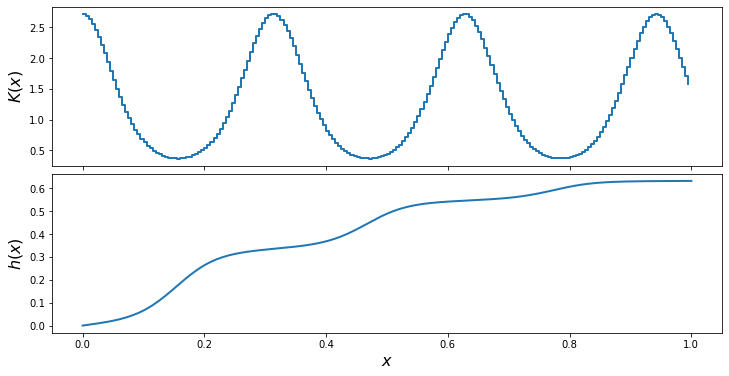

In [5]:
fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(12,6))

axs[0].step(nodeXs[0:-1],k,linewidth=2,where='post')
axs[0].set_ylabel('$K(x)$',fontsize=16)

axs[1].plot(nodeXs,h,linewidth=2)
axs[1].set_ylabel('$h(x)$',fontsize=16)
axs[1].set_xlabel('$x$', fontsize=16)
plt.subplots_adjust(hspace=0.05)
plt.show()

## Check Model Gradient
To check our adjoint gradient implementation, we will employ a finite difference approximation of the gradient vector.  Before doing that however, we need to define a scalar "objective function" $J(h)$ that can be composed with the flow equation model.   In practice, this objective function is often the likelihood function or posterior density in a Bayesian inverse problem.  For simplicity, we will just consider the log of a standard normal density:
$$
J(h) \propto -\frac{1}{2} \|h\|^2.
$$

The following cell uses the density view of MUQ's `Gaussian` class to define $J(h)$.   The `objective` defined in this cell is just another `ModPiece` and be used in the same way as any other `ModPiece`.

In [6]:
mean = np.zeros(numCells+1)
objective = mm.Gaussian(mean).AsDensity()

To obtain the gradient of the objective function $J(h)$ with respect to the vector of cell-wise conductivities $\mathbf{k}$, we need to apply the chain rule:
$$
\nabla_{\mathbf{k}} J = \left( \nabla_h J \right) \nabla_{\mathbf{k}} h
$$
The following cell uses the `objective` object to obtain the initial sensitivity $\nabla_h J$.  This is then passed to the `Gradient` function of the flow model, which will use our adjoint implementation above to compute $\nabla_{\mathbf{k}} J$.   


In [7]:
sens = objective.Gradient(0,0,[h],np.ones(1))
grad = mod.Gradient(0,0,[k],sens)

To verify our `FlowEquation.GradientImpl` function, we can call the built in `ModPiece.GradientByFD` function to construct a finite difference approximation of the gradient.  If all is well, the finite difference and adjoint gradients will be close.

In [8]:
gradFD = mod.GradientByFD(0,0,[k],sens)

#### Plot the gradients

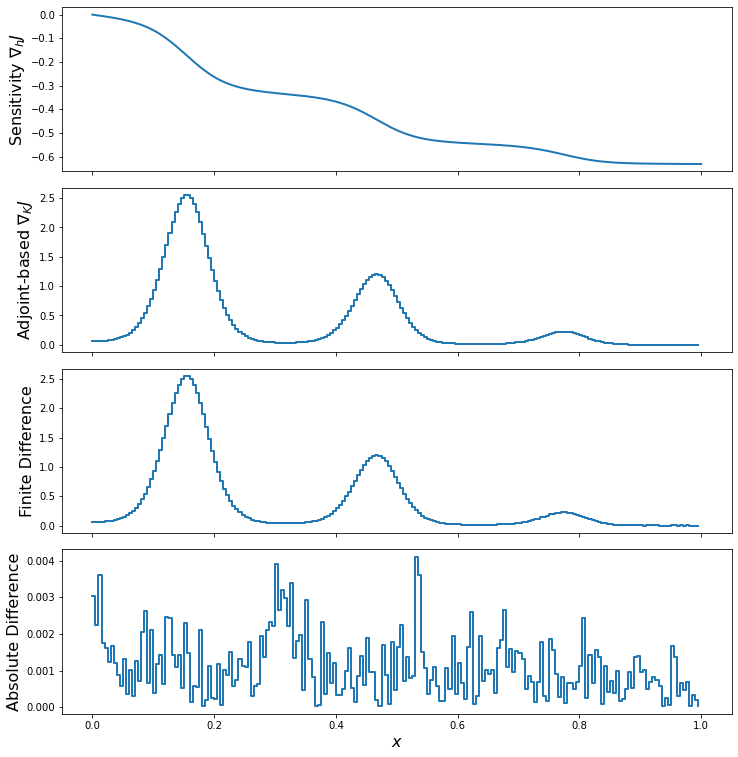

In [9]:
fig, axs = plt.subplots(nrows=4,sharex=True,figsize=(12,13))

axs[0].plot(nodeXs, sens, linewidth=2)
axs[0].set_ylabel('Sensitivity $\\nabla_h J$',fontsize=16)

axs[1].step(nodeXs[0:-1], grad, where='post',linewidth=2)
axs[1].set_ylabel('Adjoint-based $\\nabla_K J$',fontsize=16)

axs[2].step(nodeXs[0:-1], gradFD, where='post',linewidth=2)
axs[2].set_ylabel('Finite Difference',fontsize=16)

axs[3].step(nodeXs[0:-1], np.abs(grad-gradFD), where='post',linewidth=2)
axs[3].set_ylabel('Absolute Difference',fontsize=16)

axs[3].set_xlabel('$x$',fontsize=16)

plt.subplots_adjust(hspace=0.1)
plt.show()

## Test Jacobian of Model
Here we randomly choose a vector $v$ (`jacDir`) and compute the action of the Jacobian $Jv$ using both our adjoint method and MUQ's built-in finite difference implementation.

In [10]:
jacDir = np.random.randn(numCells)

jacAct = mod.ApplyJacobian(0,0,[k],jacDir)
jacActFD = mod.ApplyJacobianByFD(0,0,[k],jacDir)

#### Plot the Jacobian action
If the implementation is correct, the difference between our implementation and the finite difference implementation should be small (e.g., $<10^{-6}$).

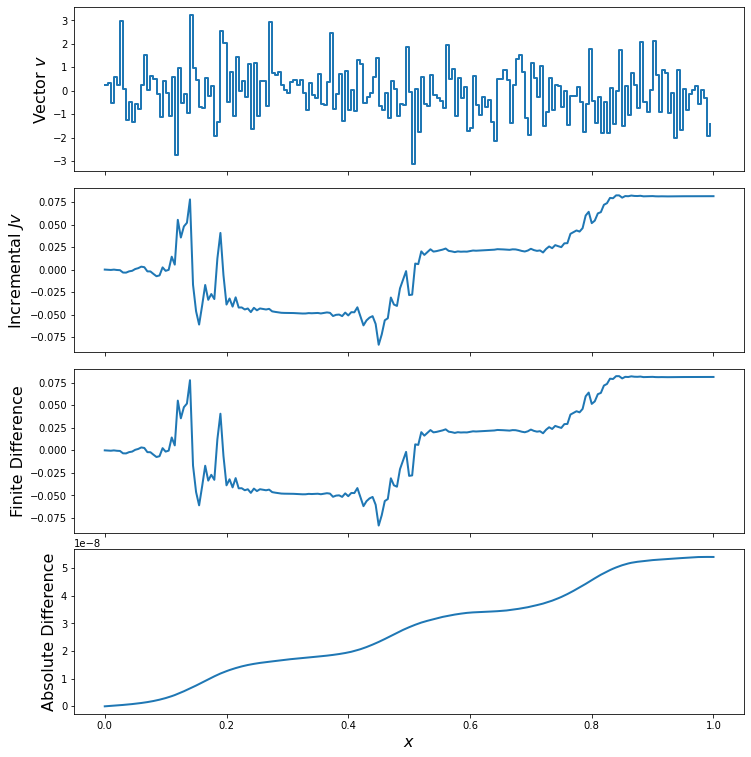

In [11]:
fig, axs = plt.subplots(nrows=4, figsize=(12,13), sharex=True)

axs[0].step(nodeXs[0:-1], jacDir, where='post', linewidth=2)
axs[0].set_ylabel('Vector $v$', fontsize=16)

axs[1].plot(nodeXs, jacAct, linewidth=2)
axs[1].set_ylabel('Incremental $Jv$',fontsize=16)

axs[2].plot(nodeXs, jacActFD, linewidth=2)
axs[2].set_ylabel('Finite Difference',fontsize=16)

axs[3].plot(nodeXs, np.abs(jacAct-jacActFD), linewidth=2)
axs[3].set_ylabel('Absolute Difference',fontsize=16)
axs[3].set_xlabel('$x$', fontsize=16)

plt.subplots_adjust(hspace=0.1)
plt.show()

## Test Hessian of Model
We now take a similar approach to verifying our Hessian action implementation.  Here we randomly choose a vector $v$ (`hessDir`) and compute $Hv$ using both our adjoint method and MUQ's built-in finite difference implementation.

In [12]:
hessDir = np.random.randn(numCells)

hessAct = mod.ApplyHessian(0,0,0,[k],sens,hessDir)
hessActFD = mod.ApplyHessianByFD(0,0,0,[k],sens,hessDir)

#### Plot Hessian actions

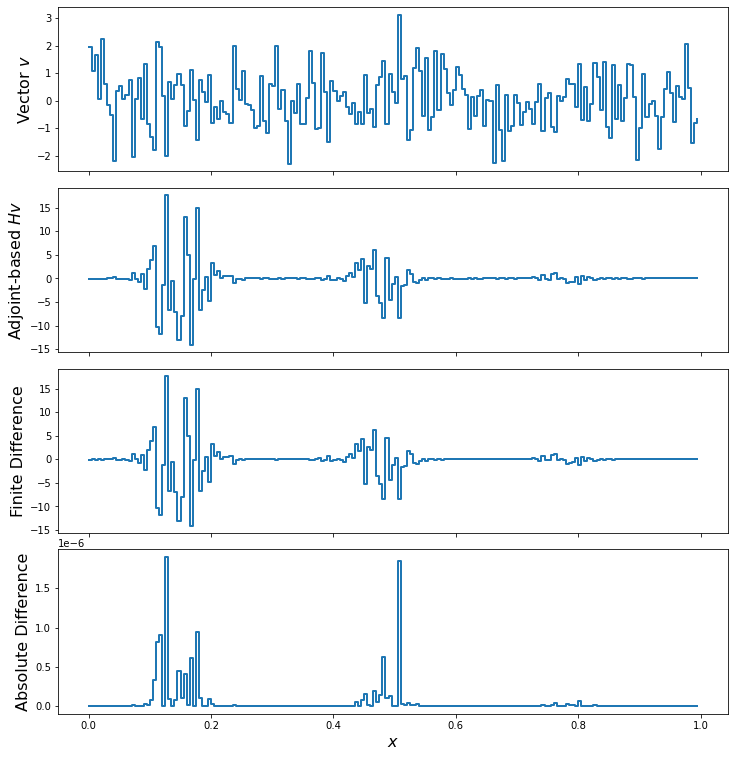

In [13]:
fig, axs = plt.subplots(nrows=4, figsize=(12,13), sharex=True)

axs[0].step(nodeXs[0:-1], hessDir, where='post', linewidth=2)
axs[0].set_ylabel('Vector $v$', fontsize=16)

axs[1].step(nodeXs[0:-1], hessAct, where='post', linewidth=2)
axs[1].set_ylabel('Adjoint-based $Hv$',fontsize=16)

axs[2].step(nodeXs[0:-1], hessActFD, where='post', linewidth=2)
axs[2].set_ylabel('Finite Difference',fontsize=16)

axs[3].step(nodeXs[0:-1], np.abs(hessAct-hessActFD), where='post', linewidth=2)
axs[3].set_ylabel('Absolute Difference',fontsize=16)
axs[3].set_xlabel('$x$', fontsize=16)

plt.subplots_adjust(hspace=0.1)
plt.show()

## Test Hessian of Objective
In the tests above, we manually evaluate the `objective` and `mod` components separately.   They can also be combined in a MUQ `WorkGraph`, which is more convenient when a large number of components are used or Hessian information needs to be propagated through multiple different components.

The following code creates a `WorkGraph` that maps the output of the flow model to the input of the objective function.   It then creates a new `ModPiece` called `fullMod` that evaluates the composition $J(h(k))$.   

In [14]:
graph = mm.WorkGraph()
graph.AddNode(mod, 'Model')
graph.AddNode(objective, 'Objective')
graph.AddEdge('Model',0,'Objective',0)

fullMod = graph.CreateModPiece('Objective')

As before, we can apply the Hessian of the full model to the randomly generated `hessDir` vector and compare the results with finite differences.   Notice that the results shown here are slightly different than the Hessian actions computed above.  Above, we manually fixed the sensitivity $s$ independently of $h$ and did not account for the relationship between the conductivity $k$ on the sensitivity $s$.   The `WorkGraph` however, captures all of those dependencies.

In [15]:
sens = np.ones(1)

hessAct = fullMod.ApplyHessian(0,0,0,[k],sens,hessDir)
hessActFD = fullMod.ApplyHessianByFD(0,0,0,[k],sens,hessDir)

#### Plot the full Hessian actions

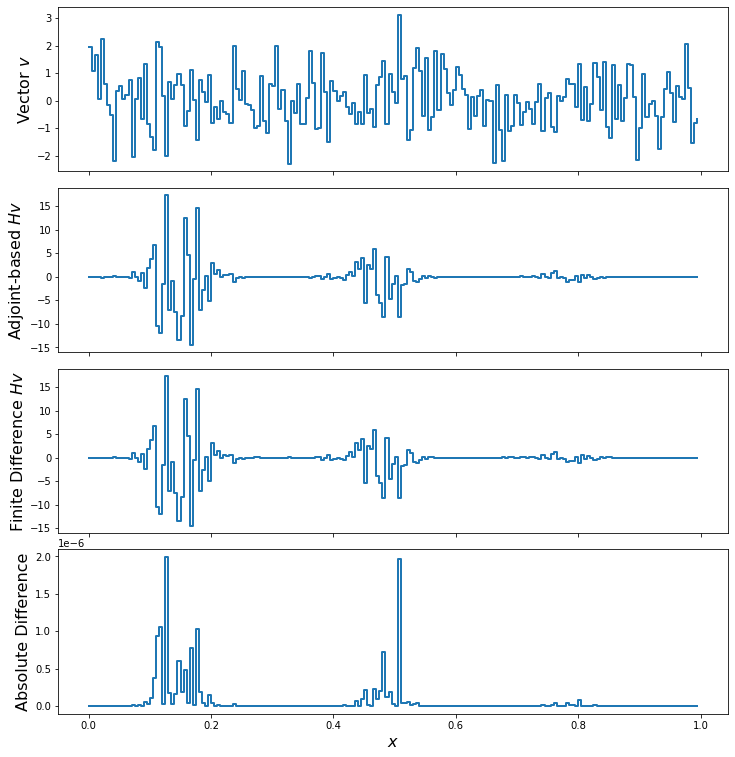

In [16]:
fig, axs = plt.subplots(nrows=4, figsize=(12,13), sharex=True)

axs[0].step(nodeXs[0:-1], hessDir, where='post', linewidth=2)
axs[0].set_ylabel('Vector $v$', fontsize=16)

axs[1].step(nodeXs[0:-1], hessAct, where='post', linewidth=2)
axs[1].set_ylabel('Adjoint-based $Hv$',fontsize=16)

axs[2].step(nodeXs[0:-1], hessActFD, where='post', linewidth=2)
axs[2].set_ylabel('Finite Difference $Hv$',fontsize=16)

axs[3].step(nodeXs[0:-1], np.abs(hessAct-hessActFD), where='post', linewidth=2)
axs[3].set_ylabel('Absolute Difference',fontsize=16)
axs[3].set_xlabel('$x$', fontsize=16)

plt.subplots_adjust(hspace=0.1)
plt.show()

## Compute the Hessian Spectrum
In many applications, the eigen decomposition of a Hessian matrix can contain valuable information.   For example, let $\pi(y|k)$ denote the likelihood function in a Bayesian inverse problem.   The spectrum of $-\nabla_{kk}\log\pi(y|k)$ (the Hessian of the negative log likelihood) describes which directions in the parameter space are informed by the data.   

Below we show how the spectrum of the Hessian can be computed with MUQ's stochastic eigenvalue solver.   MUQ's implementation is based on the generalized eigenvalue solver described in [Saibaba et al., 2015](https://doi.org/10.1002/nla.2026) and [Villa et al., 2021](https://dl.acm.org/doi/abs/10.1145/3428447?casa_token=2mk_QQqHe0kAAAAA%3AT5lr3QwgwbKNB4WgxUf7oPgCmqzir2b5O61fZHPEzv3AcU5eKHAxT1f7Ot_wZOL_SGqxe8g5ANAEtw).

#### Define the linear operator
The first step is to define a `LinearOperator` that evaluates the Hessian actions at a point.   Here, we create an instance of MUQ's `HessianOperator` class, which will internally call the `ApplyHessian` function of the `fullMod` `ModPiece`.   The inputs to the `HessianOperator` constructor are essentially the same as the `ApplyHessian` function, but with an additional scaling term.   Here, `scaling=-1` is used to account for the fact that we want to use the Hessian of the *negative* log density, which will have a positive semi-definite Hessian.

In [17]:
outWrt = 0 # There's only one output of "fullMod", so this is the only possibility
inWrt1 = 0 # There's also only one input of "fullMod"
inWrt2 = 0

scaling = -1.0
hessOp = mm.HessianOperator(fullMod, [k], outWrt, inWrt1, inWrt2, sens, scaling)

#### Set up the eigenvalue solver
We can now set up the eigen solver, compute the decomposition, and extract the eigenvalues and eigenvectors.  For more information, see documentation for the [StochasticEigenSolver](https://mituq.bitbucket.io/source/_site/latest/classmuq_1_1Modeling_1_1StochasticEigenSolver.html) class.

In [18]:
opts = {
    'NumEigs' : numCells, # Maximum number of eigenvalue/eigenvector pairs to compute
    'Verbosity':3 # Controls how much information is printed by the solver.  0=nothing, 3=everything
}

solver = mm.StochasticEigenSolver(opts)
solver.compute(hessOp)

vals = solver.eigenvalues()
vecs = solver.eigenvectors()

Converged: All nonzero eigenvalues have been found (likely) or samples are degenerate (unlikely).
Converged: Reached maximum number of eigenvalues.


#### Plot the eigenvalue spectrum
Below we plot the eigenvalues, which are sorted largest to smallest.  There are `numCells` parameters in this model and `numCells+1` outputs.   The objective function in this example is similar to what we would see if all outputs were observed.   The sharp decrease in the eigenvalues shown here is an indication that observing the `numCells+1` outputs of this model is not sufficient to completely constrain all of the `numCells` inputs.  Without additional regularization, an inverse problem using this model would therefore be ill-posed.  This is a common feature of diffusive models.

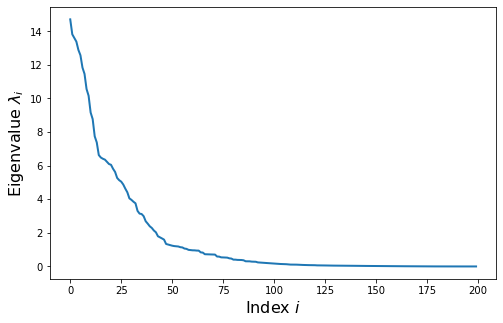

In [19]:
plt.figure(figsize=(8,5))
plt.plot(vals,linewidth=2)
plt.ylabel('Eigenvalue $\lambda_i$',fontsize=16)
plt.xlabel('Index $i$',fontsize=16)
plt.show()